# ATML2021 Assignment 3 Nalet Meinen

In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import PIL.Image as Image
import pandas as pd
import random

In [2]:
!nvidia-smi

Sun May 16 17:26:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.118.02   Driver Version: 440.118.02   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 34%   42C    P5    19W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 36%   45C    P5    29W / 250W |      0MiB / 11175MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
        

Here we implement the dataset class, create the training, validation and test sets and the dataloaders.

In [3]:
class LabeledDataset(Dataset):
    def __init__(self, folder_path, phase='train', transform=None):
        super(LabeledDataset, self).__init__()
        self.phase = phase
        if self.phase == 'train':
            file_path = os.path.join(folder_path, 'train_32x32_500_label.npz')
        elif self.phase == 'val':
            file_path = os.path.join(folder_path, 'test_32x32_2000_label.npz')
        elif self.phase == 'test':
            file_path = os.path.join(folder_path, 'test_32x32_competition.npy')
        else:
            print('Unrecognized phase')
        data_load = np.load(file_path)
        
        if self.phase != 'test':
            self.dataset = data_load['img']
            self.labels = data_load['label'].astype('int64')
        else:
            self.dataset = data_load
            
        self.transform = transform
        
    def __getitem__(self, index): 
        img_index = Image.fromarray(self.dataset[index,:])
        if self.phase != 'test':
            return self.transform(img_index), self.labels[index,0]
        else:
            return self.transform(img_index)

    def __len__(self):
        return self.dataset.shape[0]

In [4]:
transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                             ])

train_set = LabeledDataset('.', phase='train', transform=transform)
val_set = LabeledDataset('.', phase='val', transform=transform)
test_set = LabeledDataset('.', phase='test', transform=transform)

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Label: 7
Image shape: torch.Size([3, 32, 32])


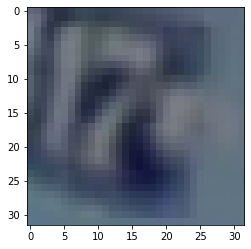

In [5]:
sample_image = train_set[0]
plt.imshow(sample_image[0].permute(1,2,0)*0.5 + 0.5)
print("Label:", sample_image[1])
print("Image shape:", sample_image[0].shape)

Let us define a fully-convolutional classifier.

In [6]:
class ClassifierNet(nn.Module):
    def __init__(self, ndf=64, nc=3, num_classes=10):
        super(ClassifierNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1),
            nn.BatchNorm2d(ndf),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
            nn.BatchNorm2d(ndf * 2),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),
            nn.BatchNorm2d(ndf * 4),
            nn.ReLU(inplace=True)
        )
        self.classification_head = nn.Sequential(
            nn.Conv2d(ndf * 4, num_classes, 4, 1, 0)
        )
        
    def forward(self, img):
        output = self.conv1(img)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.classification_head(output)
        return output.squeeze(3).squeeze(2)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ClassifierNet().to(device)

In [8]:
noise = torch.randn(4, 3, 32, 32, device=device)
out = model(noise)
print("Model output shape:", out.size())

Model output shape: torch.Size([4, 10])


Define the criterion and the optimizer.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the model for 20 epochs.

In [10]:
for epoch in range(20):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
            running_loss = 0.0

Test the model on the validation set.

In [11]:
correct = 0
total = 0
total_loss = 0
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()

print('Accuracy of the network on the 2000 validation images: %d %%' % (
    100 * correct / total))
print('Val loss', total_loss / len(val_loader))

Accuracy of the network on the 2000 validation images: 57 %
Val loss 1.4588234722614288


We expect similar accuracy on the leaderboard. However, the overfitting is clear. Let us prepare the submission file.

In [12]:
predictions = np.array([])

with torch.no_grad():
    for data in test_loader:
        inputs = data
        inputs = inputs.to(device)
        
        outputs = model(inputs)
            
        _, predicted = torch.max(outputs.data, 1)
        predictions = np.append(predictions, predicted.cpu())

In [13]:
predictions = pd.DataFrame({
    "Id": np.arange(predictions.size),
    "Category": predictions},
    dtype=np.int64)

In [14]:
predictions.to_csv("baseline_predictions.csv", index=False)